 ## Example 1: Mass-spring-damper system or electrical R-C-L (bond-graph model simulation)
This example aims to show the capability of provided tools and some steps is not mandatory for simulation.

In [1]:

import sys
sys.path.append("../")
from core.base import ElementFactory
from core.BondGraph2 import BondGraphModel
from rules.engine import RuleEngine
from equations.generator import EquationGenerator
from equations.statespace import CauchyFormGenerator
from equations.statespace import StateSpaceBuilder

from numerical.simulation import BondGraphSimulator


from inout.visualizer import draw_bond_graph, custom_layered_layout

import networkx as nx
import numpy as np


# Create a bond graph RLC with junctions

In [2]:
model = BondGraphModel("RLC with junctions")

# Create elements
se = ElementFactory.create('SE')
r = ElementFactory.create('R')
i = ElementFactory.create('I')
c = ElementFactory.create('C')
sf = ElementFactory.create('SF')

j1_1 = ElementFactory.create('1')  # 1-junction for SE and I
j1_2 = ElementFactory.create('1')  # 1-junction for 0 - RС
j0_0 = ElementFactory.create('0')  # 0-junction between R and C
j1_3 = ElementFactory.create('1')  # 1-junction for SF


# Connect components properly using junctions
model.connect(se, j1_1)   # SE -> j1_1
model.connect(i, j1_1)    # I -> 1-junction 1

model.connect(r, j1_2)    # R -> 1-junction 2
model.connect(c, j1_2)    # C -> 1-junction 2

model.connect(j1_1, j0_0)    # 0junction -> 1-junction 1
model.connect(j0_0, j1_3)    # 0junction -> 1-junction 3
model.connect(j0_0, j1_2)    # 0junction -> 1-junction 2

model.connect(j1_3, sf)    # 1-junction 3 -> SF



In [3]:
# Apply causality rules
engine = RuleEngine(model, debug=False)
engine.apply_all()
# engine.assign_sources_ports()

There is valid ckecking in apply_all() but if you want, yu can make double check

In [4]:
# problems = engine.find_invalid_bonds()
# if problems:
#     print("Detected some unvalid bonds:")
#     for p in problems:
#         print(p)
# else:
#     print("Allrights!")

In [5]:
# ONLY FOR DEBUGING (IF U NEED) just printes the internal params of model
# model.debug_display_elements_with_ports()

In [6]:
# ONLY FOR DEBUGING (IF U NEED)
# model.debug_display_bonds()

In [ ]:
# for bond in model.bonds:
#     # Найти элементы, связанные с bond.from_port и bond.to_port
#     from_elem = next((e for e in model.elements if bond.from_port in e.ports), None)
#     to_elem = next((e for e in model.elements if bond.to_port in e.ports), None)
#     print(f"Bond {bond.id}:")
#     print(f"  FROM: {from_elem.name if from_elem else '???'} [{bond.from_port.name}]"
#           f" (direction={bond.from_port.direction}, causality={bond.from_port.causality})")
#     print(f"  TO:   {to_elem.name if to_elem else '???'} [{bond.to_port.name}]"
#           f" (direction={bond.to_port.direction}, causality={bond.to_port.causality})")
#     print("-" * 40)

In [ ]:
# # Causality and direction output for ports
# for elem in model.elements:
#     print(elem.name)
#     for port in elem.ports:
#         print(f"{elem.name}: Port {port.name} -> direction={port.direction}, causality={port.causality}")

In [35]:
# element = model.find_element_by_port_name("Port_6")
# element.name

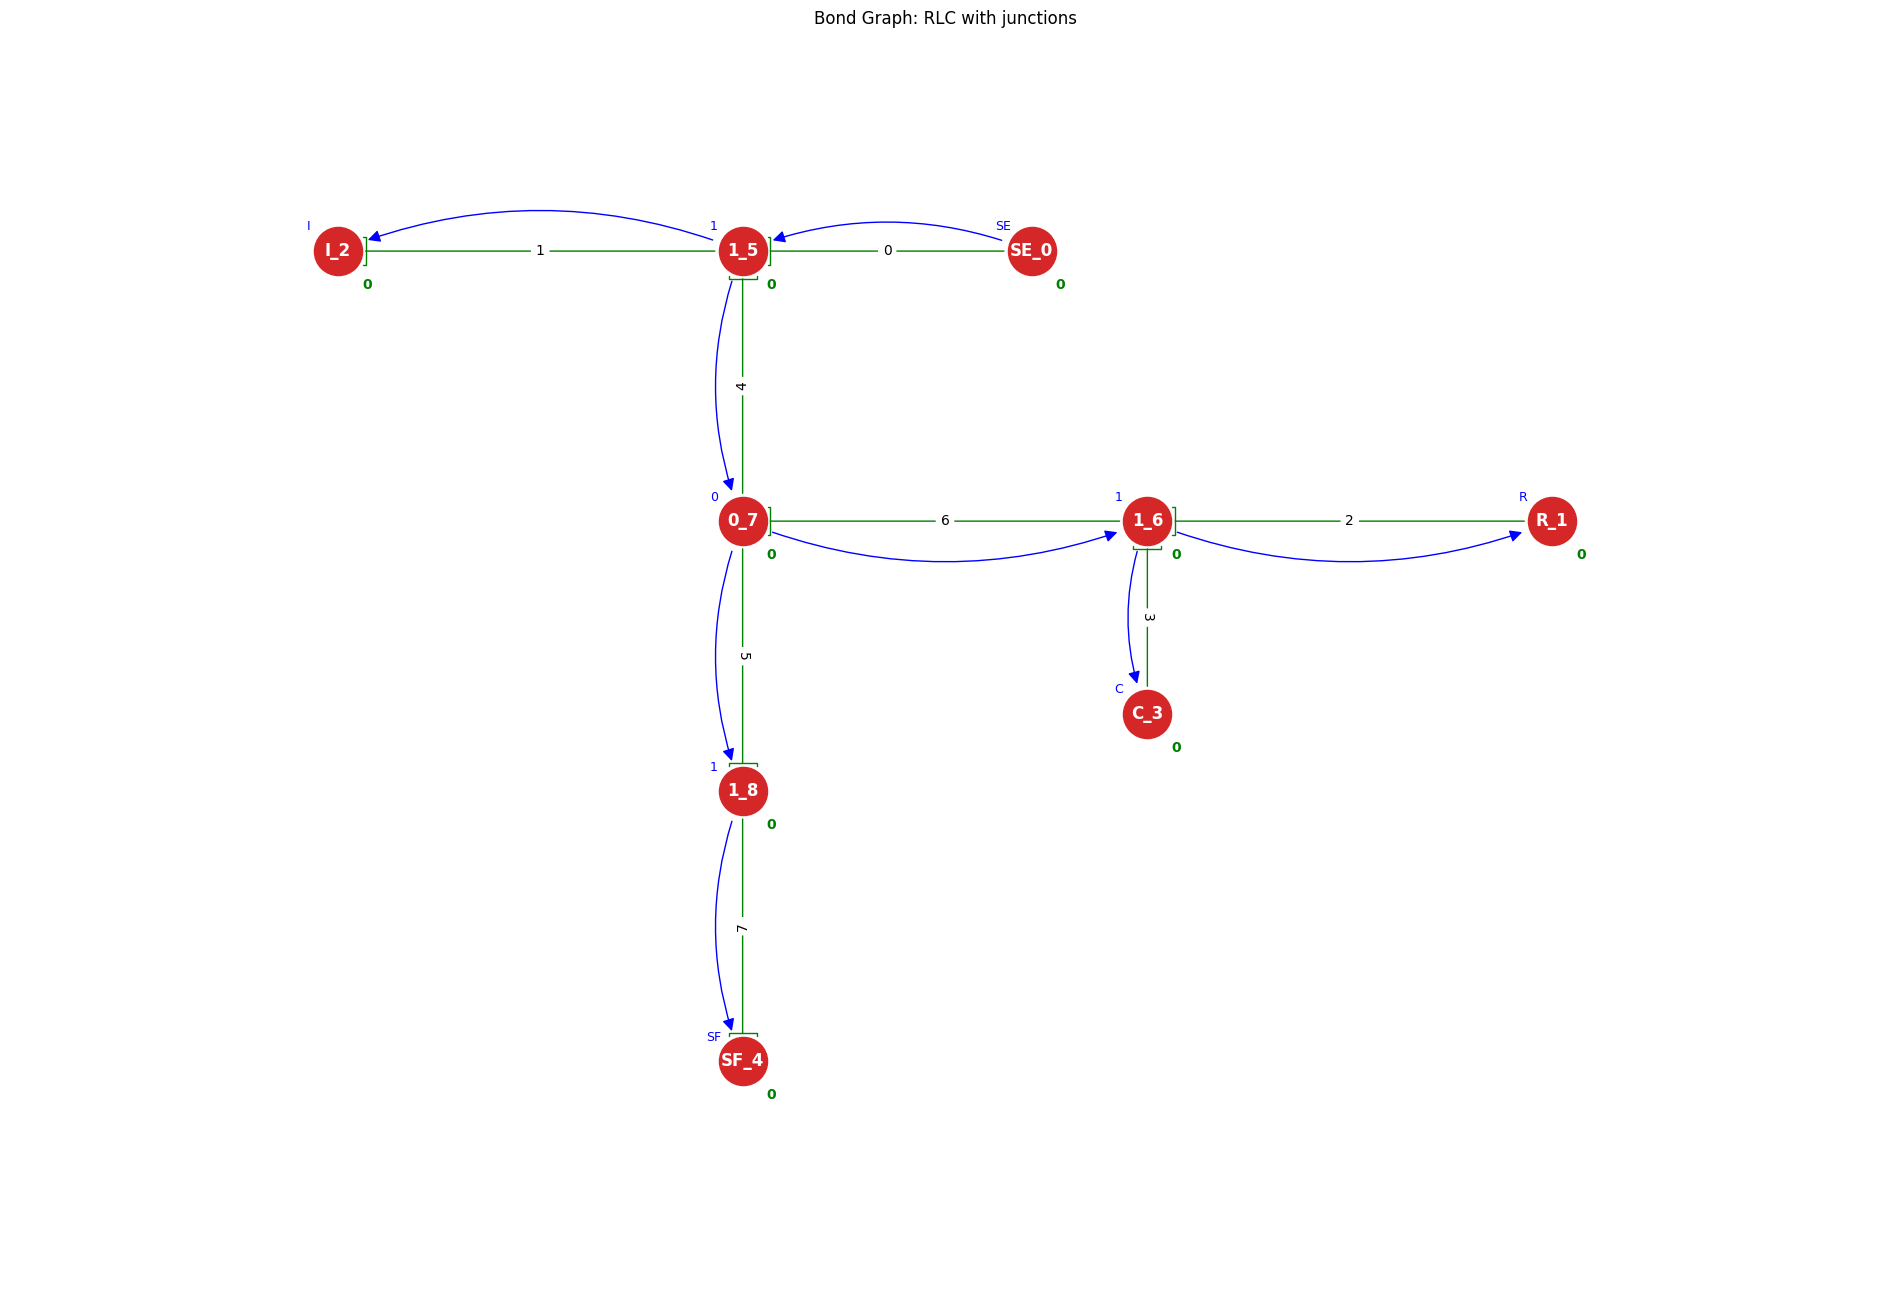

In [7]:

custom_layered_layout(model)

# Draw the graph
draw_bond_graph(model)

In [8]:
# 5) Generate equations (NOT REQUIRED later... Cochy will do it)
eqgen = EquationGenerator(model, debug=False)
eqs = eqgen.generate_equations()
# eqgen.visualize_equations()
# print(eqs)


Eq(f1, f0)
Eq(f4, f0)
Eq(f3, f2)
Eq(f6, f2)
Eq(f7, f5)


In [9]:


cform = CauchyFormGenerator(model, debug=False)
eqs = cform.build_cauchy_form()

Eq(f1, f0)
Eq(f4, f0)
Eq(f3, f2)
Eq(f6, f2)
Eq(f7, f5)


In [10]:
print("User have to define the output variables for the system to make possive the output equations generation")
cform.get_all_ef_variables()

cform.interactive_generate_output_equations()

User have to define the output variables for the system to make possive the output equations generation
Eq(e6, -R1*SF4 + R1*p2/I2 + q3/C3)
Eq(f6, -SF4 + p2/I2)


[Eq(e6, -R1*SF4 + R1*p2/I2 + q3/C3), Eq(f6, -SF4 + p2/I2)]

In [11]:
print("Сauchy form equations:")
cform.cauchy_equations[0], cform.cauchy_equations[1]

Сauchy form equations:


(Eq(dotp2, R1*SF4 + SE0 - R1*p2/I2 - q3/C3), Eq(dotq3, -SF4 + p2/I2))

In [12]:
print("Output equations: ")
cform.output_eqs[0], cform.output_eqs[1]

Output equations: 


(Eq(e6, -R1*SF4 + R1*p2/I2 + q3/C3), Eq(f6, -SF4 + p2/I2))

In [13]:
cform.final_vars

{C3, I2, R1, SE0, SF4, p2, q3}

## Make A B С D-matrix
Now we can set the input variables and get С-D-matrix

In [14]:
ssb = StateSpaceBuilder(model, cform, debug=False)
A, B, C, D = ssb.build_state_space()

Matrix([[0, 0], [0, 0]]) Matrix([[0, 0], [0, 0]])


In [15]:
ssb.x_vars, ssb.u_vars

({p2, q3}, {SE0, SF4})

In [16]:
A, B , C, D 

(Matrix([
 [-1/C3, -R1/I2],
 [    0,   1/I2]]),
 Matrix([
 [R1, 1],
 [-1, 0]]),
 Matrix([
 [1/C3, R1/I2],
 [   0,  1/I2]]),
 Matrix([
 [-R1, 0],
 [ -1, 0]]))

## Make numerical matrixes from symbolic

In [18]:
sim = BondGraphSimulator(model, ssb)


## Make simulation

In [19]:

import matplotlib.pyplot as plt

sim.print_simulation_requirements()  # shows the required parameters (order is important)



=== Required Data for Numerical Simulation ===
System parameters (provide param_values: dict[str, float]):
    C3, I2, R1
   Example: param_values = {'R1': 10.0, 'C2': 0.001, 'L3': 0.1}

State variables (provide x0: list[float], in the same order):
    q3, p2
   Example: x0 = [0.0, 0.0]   # (e.g., q2=0, p3=0)

Input variables (provide u_func: Callable[[float], list[float]], in the same order):
    SF4, SE0
   Example: u_func = lambda t: [1.0]   # if a single input, e.g., SE0=1 always
           u_func = lambda t: [np.sin(t)]  # sinusoidal input
-------------------------------------------------------
Full function call:
  result = sim.simulate(param_values, t_span=(0, 5), x0=x0, u_func=u_func)
  t, y = result['t'], result['y']


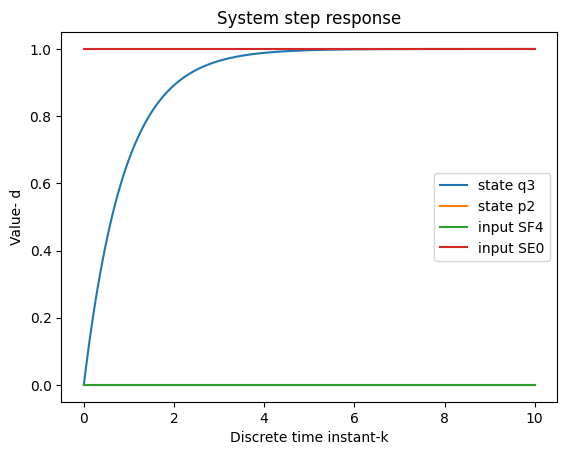

In [33]:
initial_state = [0.0, 0.0]
num_steps  = 501
input_sequence = [[0.0, 1.0] for _ in range(num_steps)] # input values on simulation time

# input_sequence[0][0] = 1.0
# input_sequence[0][1] = 1.0

# OR: input_sequence = [[np.sin(t)] for t in np.linspace(0, 5, num_steps)]
simulation_time_to = 10 # sec
time_steps = np.linspace(0, simulation_time_to, num_steps)
sampling_period = time_steps[1] - time_steps[0] # sampling_period=0.05
parameter_values = {'C3': 1/1.1, 'I2': 1.01, 'R1': 1.01} # С is complaence (not stifness K)

result = sim.simulate(initial_state, input_sequence, time_steps, sampling_period, parameter_values)

for ix, state_name in enumerate(sim.ss.x_vars):
    plt.plot(result['t'], result['y'][:,ix], label={"state " + str(state_name)})
    
for ix, input_name in enumerate(sim.ss.u_vars):
    plt.plot(result['t'], result['u'][:,ix], label={"input "+ str(input_name)})

plt.xlabel('Discrete time instant-k')
plt.ylabel('Value- d')

plt.title('System step response')
plt.legend()
plt.show()

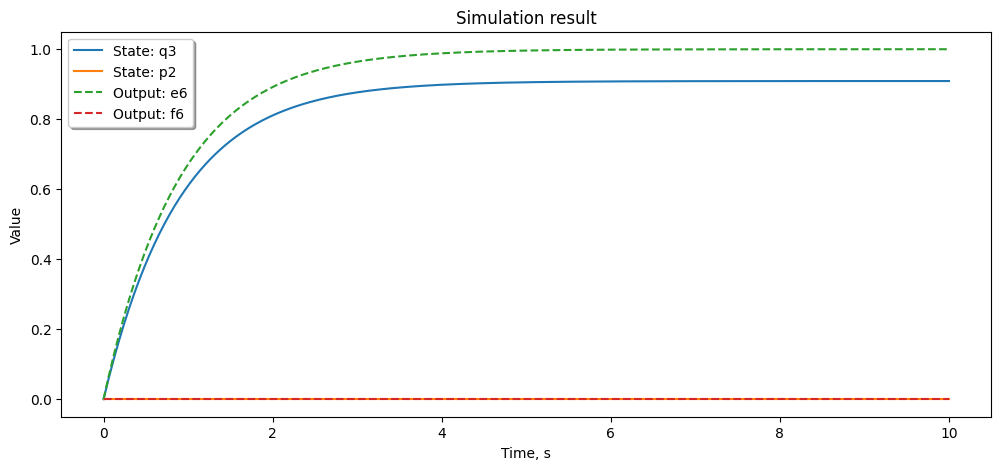

In [34]:
state_names = [str(s) for s in sim.ss.x_vars]        # ['q2', 'p3', ...]
output_names = [str(y) for y in sim.ss.output_vars]  # ['e4', 'f7', ...]

sim.plot_simulation_result(result, state_names, output_names)

In [22]:
plt.plot(state[0,:-1], label='q')
plt.plot(state[1,:-1], label='p')
plt.xlabel('Discrete time instant-k')
plt.ylabel('Value- d')
plt.title('System step response')
plt.legend()

NameError: name 'state' is not defined

AS WE CAN SEE MASS_SPRING SYSTEM BECAME STABLE OVER TIME